# Spaceship Titanic Kaggle Challenge

Objective: To predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help make these predictions, there is a set of personal records recovered from the ship's damaged computer system.


# Imports

In [329]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as mno
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import set_config
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Load data and EDA

In [332]:
train_df = pd.read_csv('/Users/jennatan/code/jennajt/Titanic /Data/train.csv')
test_df = pd.read_csv('/Users/jennatan/code/jennajt/Titanic /Data/test.csv')

In [333]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [334]:
print(f'(Train shape: {train_df.shape}, Test shape: {test_df.shape}')

(Train shape: (8693, 14), Test shape: (4277, 13)


In [335]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


**A number of columns need to be changed to floats or ints**

In [336]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


**The numeric features are on different scales and there are missing values**

In [337]:
train_df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [338]:
train_df.Transported.value_counts()/len(train_df)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

**The target is evenly distributed**

In [339]:
# drop duplicates
train_df.duplicated().sum()
test_df.duplicated().sum()

0

**There are no duplicates**

In [340]:
# detect % of missing data
train_df.isnull().sum().sort_values(ascending=False)/len(train_df)

CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
Name            0.023007
Cabin           0.022892
VRDeck          0.021627
FoodCourt       0.021051
Spa             0.021051
Destination     0.020936
RoomService     0.020821
Age             0.020591
PassengerId     0.000000
Transported     0.000000
dtype: float64

**Almost every column has missing data**

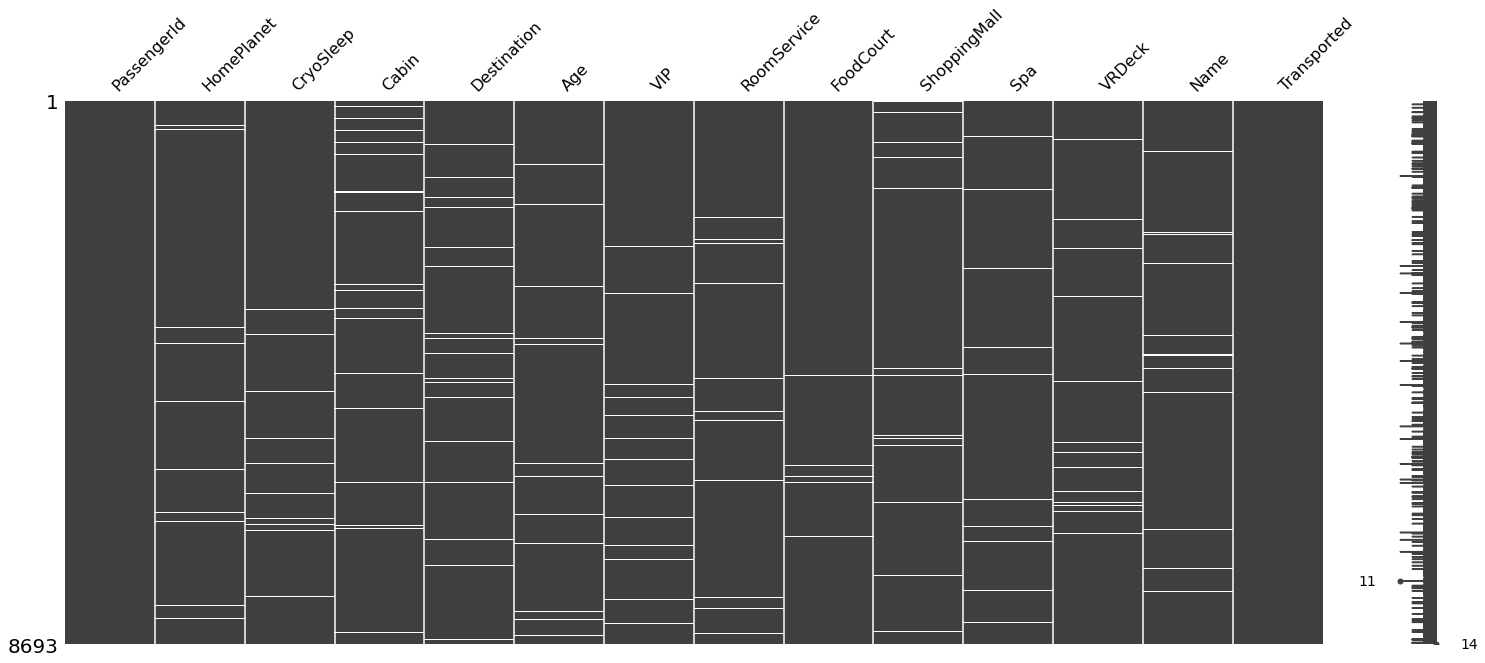

In [341]:
mno.matrix(train_df);

**There is no pattern to the missing values**

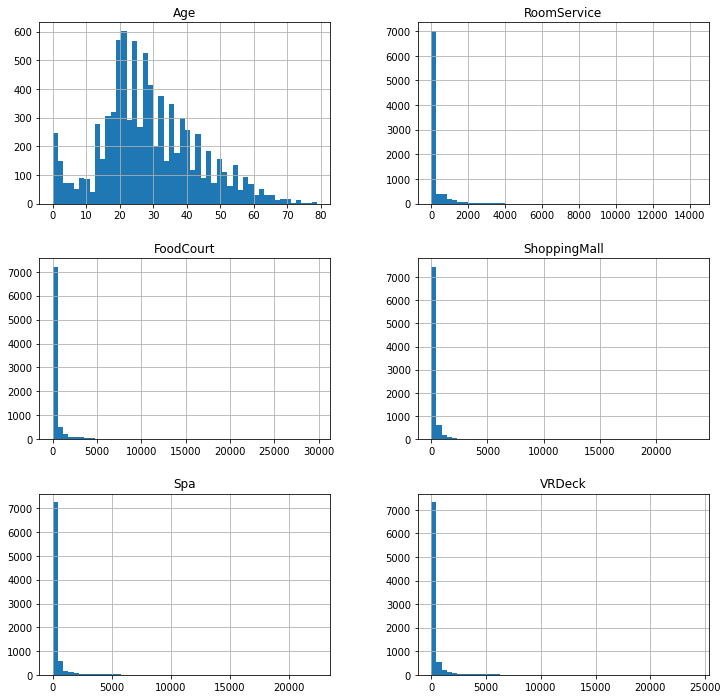

In [342]:
train_df.hist(bins=50, figsize=(12,12));

**- Histograms are not normally distributed - use MinMaxScaler & split age into bins**

<AxesSubplot:>

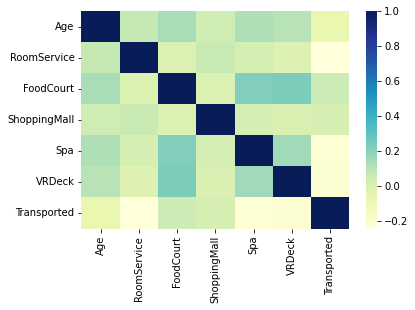

In [343]:
corr = train_df.corr()
sns.heatmap(corr, cmap = 'YlGnBu')

In [344]:
corr_df = corr.unstack().reset_index()
corr_df.columns = ['Feature_1','Feature_2','Correlation']
corr_df.sort_values(by='Correlation', ascending=False,inplace=True)
corr_df = corr_df[corr_df['Feature_1'] != corr_df['Feature_2']]
corr_df.head()

,Feature_1,Feature_2,Correlation
37,VRDeck,FoodCourt,0.227995
19,FoodCourt,VRDeck,0.227995
30,Spa,FoodCourt,0.221891
18,FoodCourt,Spa,0.221891
39,VRDeck,Spa,0.153821


**No strong correlations**

# Preprocess data

## Replace nulls

In [345]:
# replace null values with median for numerical cols and most frequent for categorical cols
def replace_null(df):
    numeric = [col for col in df.select_dtypes(['int','float'])]
    categoric = [col for col in df.select_dtypes(['object'])]

    for col in numeric:
        df[col].fillna(df[col].median(),inplace=True)

    for col in categoric:
        df[col].fillna(df[col].value_counts().index[0],inplace=True)
    
    return df

In [346]:
train_df = replace_null(train_df)
test_df = replace_null(test_df)

## Scale num features

In [347]:
# Min-max scaler for num cols as it is efficient regardless of distribution
def scale(df):
    scaler = MinMaxScaler()
    scaler.fit(df[['Age','RoomService','FoodCourt','ShoppingMall','Spa',
                'VRDeck']])
    df[['Age','RoomService','FoodCourt','ShoppingMall','Spa',
                'VRDeck']] = scaler.transform(df[['Age','RoomService','FoodCourt','ShoppingMall','Spa',
                'VRDeck']])
    return df

In [348]:
train_df = scale(train_df)
test_df = scale(test_df)

## Encode HomePlanet and Destination

In [349]:
# OHE HomePlanet and Destination
def OHE_home(df):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(df[['HomePlanet']])
    df['Europa'],df['Earth'], df['Mars'] = (ohe.transform(df[['HomePlanet']])).T
    df.drop(columns=['HomePlanet'],inplace=True)
    return df

def OHE_destination(df):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(df[['Destination']])
    df['TRAPPIST_1e'],df['PSO_J318.5_22'], df['55_Cancri_e'] = (ohe.transform(df[['Destination']])).T
    df.drop(columns=['Destination'],inplace=True)
    return df

In [350]:
train_df = OHE_home(train_df)
test_df = OHE_home(test_df)

In [351]:
train_df = OHE_destination(train_df)
test_df = OHE_destination(test_df)

## Split PassengerID

In [352]:
# Split the passenger ID into its group and number, replace Group with its value count, drop nuumber col
def passenger(df):
    df[['Group','Number']] = df.PassengerId.str.split("_",expand=True)
    GroupSize= df.Group.value_counts()
    df['Group'] = df['Group'].map(GroupSize)
    df.drop(columns=['Number'],inplace=True)
    return df
    

In [353]:
train_df = passenger(train_df)
test_df = passenger(test_df)

## Split Cabin

In [354]:
# Separate the Deck, Num and Side from Cabin
def cabin(df):
    df[['Deck','Num','Side']] = df.Cabin.str.split("/",expand=True)
    
    
    df.replace({'Side': {'S': True, 'P': False}},inplace=True)
    df.rename(columns={'Side':'S'},inplace=True)
    
    df.drop(columns=['Cabin','Deck','Num'],inplace=True)
    return df

In [355]:
train_df = cabin(train_df)
test_df = cabin(test_df)

## Reset index and delete final columns

In [356]:
def reset_index(df):
    df = df.set_index('PassengerId')
    df = df.drop(columns='Name')
    return df

In [357]:
train_df = reset_index(train_df)
test_df = reset_index(test_df)

# Modelling

In [285]:
X_train = train_df.drop(columns=['Transported'])
y_train = train_df[['Transported']]

In [286]:
X_train.head(2)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Europa,Earth,Mars,TRAPPIST_1e,PSO_J318.5_22,55_Cancri_e,Group,S
PassengerId,,,,,,,,,,,,,,,,
0001_01,False,0.493671,False,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,1,False
0002_01,False,0.303797,False,0.007608,0.000302,0.001064,0.0245,0.001823,1.0,0.0,0.0,0.0,0.0,1.0,1,True


In [287]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,train_size=0.7)

## Baseline

In [288]:
# Baseline
baseline = DummyClassifier(strategy='stratified')

# Train the baseline classifier
baseline.fit(X_train,y_train)

# Test the classifier
baseline.score(X_val,y_val)

0.4927147239263804

## Logistic Regression

In [289]:
log_model = LogisticRegression().fit(X_train,y_train)
log_model.score(X_val,y_val)

0.7611196319018405

In [290]:
# Fine tune logistic regression with GridSearch

grid = {'penalty':['l1','l2','elasticnet'], 'solver':['lbfgs','newton-cg']}

search = GridSearchCV(log_model,grid,scoring='accuracy',cv=5)
search.fit(X_train,y_train)
search.best_params_
best_log_model = search.best_estimator_

In [291]:
search.best_score_

0.7625308134757601

In [292]:
y_pred = best_log_model.predict(X_val)

In [293]:

print('Accuracy =', round(accuracy_score(y_val, y_pred), 2)) # Accuracy
print('Precision =', round(precision_score(y_val, y_pred), 2)) # Precision
print('Recall =', round(recall_score(y_val, y_pred), 2)) # Recall
print('F1 score =', round(f1_score(y_val, y_pred), 2)) # F1 score
print('AUC score =', round(roc_auc_score(y_val,y_pred),2)) # AUC

Accuracy = 0.76
Precision = 0.8
Recall = 0.71
F1 score = 0.75
AUC score = 0.76


## SGD Classifier

In [294]:
sgd_model = SGDClassifier().fit(X_train,y_train)
sgd_model.score(X_val,y_val)

0.7699386503067485

In [295]:
# Fine tune SGD Classifier
grid = {'loss':['hinge','huber','epsilon_insensitive'],
        'alpha':[0.1,0.01,0.001,0.0001,0.00001]}

search = GridSearchCV(sgd_model,grid,scoring='accuracy',cv=5)
search.fit(X_train,y_train)
search.best_params_
search.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [296]:
search.best_score_

0.7544782251437961

In [297]:
y_pred = sgd_model.predict(X_val)
print('Accuracy =', round(accuracy_score(y_val, y_pred), 2)) # Accuracy
print('Precision =', round(precision_score(y_val, y_pred), 2)) # Precision
print('Recall =', round(recall_score(y_val, y_pred), 2)) # Recall
print('F1 score =', round(f1_score(y_val, y_pred), 2)) # F1 score
print('AUC score =', round(roc_auc_score(y_val,y_pred),2)) # AUC

Accuracy = 0.77
Precision = 0.79
Recall = 0.75
F1 score = 0.77
AUC score = 0.77


## XGBOOST

In [298]:
# Use XGBOOST for Extreme Gradient Tree Boosting; trained sequentially

tree = XGBClassifier()

In [299]:
tree.fit(X_train,y_train)
y_pred = tree.predict(X_val)
accuracy_score(y_val,y_pred)

[11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.781058282208589

In [300]:
# Fine tune XGBBOOST
grid = {'n_estimators':[50,100,150],
        'eta':[0.1,0.01,0.2],
       'max_depth':[2,3,5,10]}

search = GridSearchCV(tree,grid,scoring='accuracy',cv=5)
search.fit(X_train,y_train)
best_tree = search.best_estimator_

[11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[11:28:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[11:28:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[11:28:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[11:29:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[11:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[11:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

In [301]:
y_pred = best_tree.predict(X_val)
print('Accuracy =', round(accuracy_score(y_val, y_pred), 2)) # Accuracy
print('Precision =', round(precision_score(y_val, y_pred), 2)) # Precision
print('Recall =', round(recall_score(y_val, y_pred), 2)) # Recall
print('F1 score =', round(f1_score(y_val, y_pred), 2)) # F1 score
print('AUC score =', round(roc_auc_score(y_val,y_pred),2)) # AUC

Accuracy = 0.79
Precision = 0.78
Recall = 0.82
F1 score = 0.8
AUC score = 0.79


# Use best model with test data

In [309]:
y_pred_submission = best_tree.predict(test_df).astype(bool)

In [361]:
test_df = test_df.reset_index()

In [363]:
test_df['PassengerId']

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerId, Length: 4277, dtype: object

In [364]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'] , 'Transported': y_pred_submission})
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [379]:
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [381]:
submission.to_csv('submission.csv',index=False)